In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from astropy.io import fits
from scipy.stats import norm, truncnorm
import sep, glob, GCRCatalogs, matplotlib, time
from scipy.optimize import root
from tqdm import tqdm
import pandas as pd

# Main Forecast

In [2]:
#options are Zahid and Collett
method='Zahid' 
#options are 'source_in_lens' (Method A), 'lens_in_source' (Method B), and 'both' (Method C)
counting='both'
#Default number of samples is 100,000: use this to increase samples
sample_size_factor = 100
#Whether to apply condition of bulge-to-total ratio B/T> 0.9
btr_enforced = True
#home directory with data
home = "/global/cfs/projectdirs/deepsrch/jwst_sims/data/"
#Loads CosmoDC2 catalog
cat = GCRCatalogs.load_catalog("desc_cosmodc2")

In [3]:
#Collett (2015) statistics, generated using LensPop

c_sig = np.load(home+"lenspop/lens_sig_3.npy", encoding="latin1",allow_pickle=True)
c_z = np.load(home+"lenspop/lens_z_3.npy", encoding="latin1",allow_pickle=True)
c_thetaE = np.array([])
for i in range(len(c_sig)):
    lens_cosmo = LensCosmo(c_z[i],6)
    te = lens_cosmo.sis_sigma_v2theta_E(c_sig[i])
    c_thetaE = np.append(c_thetaE, te)
bins = np.arange(0,2.0,0.1)
n, bins = np.histogram(c_thetaE, bins=bins)

In [4]:
#Sets up CosmoDC2 data to be drawn from
keys = ['redshift', 'halo_mass', 'stellar_mass', 'size_true', 'ellipticity_1_true', 'ellipticity_2_true', 'is_central', 'bulge_to_total_ratio_i']
dc2 = cat.get_quantities(keys)

ra, dec = cat.get_quantities(['ra_true'])['ra_true'], cat.get_quantities(['dec_true'])['dec_true']
ra_dc2, dec_dc2 = ra-ra.mean(), dec-dec.mean()
#Parallelogram of area covered by Cosmo DC2
area_dc2 = (ra.max()-ra.min())*(dec.max()-dec.min())/2

# bins = np.logspace(9,14,21)
# plt.hist(dc2['halo_mass'][dc2['is_central']==True],bins=bins,log=True)
# plt.xscale('log')

In [5]:
#JWST star-forming and quiescent mock catalogs (Williams et al. (2018))
with fits.open(home+'JWST/JADES_SF_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    dataq = hdul[1].data
ra_source, dec_source = dataq['RA']-dataq['RA'].mean(), dataq['DEC']-dataq['DEC'].mean()

with fits.open(home+'JWST/JADES_Q_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    dataq2 = hdul[1].data
    headerq = hdul[1].header
#Selects rectangle on the sky to use
dataq = dataq[dataq['RA']>53.137];dataq = dataq[dataq['RA']<53.222]
dataq = dataq[dataq['DEC']>-27.83];dataq = dataq[dataq['DEC']<-27.785]
dataq2 = dataq2[dataq2['RA']>53.137];dataq2 = dataq2[dataq2['RA']<53.222]
dataq2 = dataq2[dataq2['DEC']>-27.83];dataq2 = dataq2[dataq2['DEC']<-27.785]

from astropy.table import Table, vstack
from astropy.io.fits import FITS_rec
data = vstack([Table(dataq),Table(dataq2)])
data['ra'] = data['RA']; data['dec']=data['DEC']

In [6]:
#Range of source redshifts
z_sources = np.logspace(np.log10(max(data['redshift'])), np.log10(min(data['redshift'])), 20)
z_source_means = (z_sources[1:]+z_sources[:-1])/2

In [7]:
#JWST image (Williams et al. (2018))
with fits.open(home+'JWST/goods_s_F115W_2018_08_29.fits') as hdul:
    data3 = hdul[0].data
    header3 = hdul[0].header
from astropy.wcs import WCS
w = WCS(header3)
from astropy.coordinates import SkyCoord
region = data3[5000:6000,7000:9000]*1
#Average background level
bkg = sep.Background(np.array(region)).globalrms
bkg

0.001607376616448164

In [8]:
with fits.open(home+'JWST/JADES_SF_mock_r1_v1.1.fits') as hdul:
#     print(hdul.info())
    data0 = hdul[1].data
    header = hdul[1].header
ra_source, dec_source = data['RA']-data['RA'].mean(), data['DEC']-data['DEC'].mean()
#'sad' is the Source Area in Degrees squared
sad = (ra_source.max()-ra_source.min())*(dec_source.max()-dec_source.min()) #source area degrees


In [9]:
#Statistical count, counting sources over lens area
import time
start = time.time()

#converts between normalization of Collett and CosmoDC2 distributions
number_ratio = 0.017399272857057335

#Total array of Einstein radii
TES=[]
#Masses of the lenses
masses_used=[]
#Sources per lens above 0.05", 0.1", 0.5", 1.0"
sources_per_lens_002, sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100 = [], [],[],[],[]

lens_masses = dc2['halo_mass'].copy()
#Lower mass limit is for speed, upper is to exclude huge cluster lenses
sel = (lens_masses>1e9)*(lens_masses<1e14)

ms = lens_masses[sel]
zs = dc2['redshift'][sel]
btr = dc2['bulge_to_total_ratio_i'][sel]
np.random.seed(5)
rng = np.random.default_rng(seed=5)
inds = rng.choice(len(ms), size=100000*sample_size_factor,replace=False)
inds = inds[dc2['is_central'][sel][inds]==True]

ms = ms[inds]
zs = zs[inds]
btr = btr[inds]
source_nums = np.zeros(len(z_source_means))
#Total lensed areas above 0.05", 0.1", 0.5", 1.0"
lens_areas_002 = np.zeros(len(z_source_means))
lens_areas_005 = np.zeros(len(z_source_means))
lens_areas_010 = np.zeros(len(z_source_means))
lens_areas_050 = np.zeros(len(z_source_means))
lens_areas_100 = np.zeros(len(z_source_means))

#Iterates over the redshift slices
for zi in (range(len(z_source_means))):
    sources = data[data['redshift']<z_sources[zi]]
    sources = sources[sources['redshift']>z_sources[zi+1]]
    
    source_areas = []

    #Counts all of the sources within the redshift bin that are bright enough
    for source in range(len(sources)):
        
        R = int(sources[source]['Re_maj']/.03*5)
        #counting if any pixel has brightness >5*BKG, using sep
        if R>0:
            ra, dec = sources[source]['RA'], sources[source]['DEC']
            sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
            x, y = w.world_to_pixel(sky)
            x, y = int(x), int(y)
            gal = data3[y-R:y+R,x-R:x+R]
            objects, segmap = sep.extract(np.array(gal).byteswap().newbyteorder(), 1.5, err=bkg, segmentation_map=True)
            segmap[segmap!=segmap[R,R]]=0
            
            if np.count_nonzero(gal[segmap!=0]>5*bkg)>=1:
                source_nums[zi] += 1
                source_areas.append(np.sum(gal[segmap!=0]>5*bkg)*(.03/60/60)**2)
       
        # #counting if brightness above a magnitude cut
        # source_areas = [0]
        # F_nu = sources[source]['HST_F775W_fnu']*1e-9
        # ABmag = -2.5*np.log10(F_nu) + 8.90
        # if ABmag < 27:
        #     source_nums[zi] += 1

    TESz = []
    masses_used_z = []
    sources_per_lens_z_002, sources_per_lens_z_005,sources_per_lens_z_010,sources_per_lens_z_050,sources_per_lens_z_100  = [], [],[],[],[]
    #Counts the total lens area at the center of the current redshift slice
    for lens in tqdm(range(len(ms)), desc="Redshift Slice "+str(1+zi)+"/"+str(len(z_source_means)), leave=False):
        if zs[lens] < z_source_means[zi] and (not btr_enforced or btr[lens]>0.9):
            lens_cosmo = LensCosmo(z_lens=zs[lens], z_source=z_source_means[zi])

            if method=='Zahid':
                alpha, beta, scatter = 0.16, 3.31, 0.17
                sig = 100*10**((np.log10(ms[lens]/1e12)-alpha)/beta)
                sig += norm.rvs(loc=0,scale=np.log(10)/beta*sig*0.17)
                
            elif method=='Collett':
                sig = np.random.choice(c_sig)
                # sig = c_sig[lens%len(c_sig)]
            else:
                raise Exception("Not a valid method.")
            
            theta_E = lens_cosmo.sis_sigma_v2theta_E(sig)
            TESz.append(theta_E)
            masses_used_z.append(ms[lens])
            
            TEarea = np.pi*(theta_E/60/60)**2
            if len(source_areas)>0:
                #Source area
                sArea = np.random.choice(source_areas)
                source_radius = np.sqrt(sArea/np.pi)
                #Total radius is how far away the lens and source can be
                if counting=='source_in_lens':
                    total_radius = theta_E/60/60
                elif counting=='lens_in_source':
                    total_radius = source_radius
                elif counting=='both':
                    total_radius = max(source_radius, theta_E/60/60)
                else:
                    raise Exception("Not a valid counting choice.")
                TEarea = np.pi*(total_radius)**2
            else:
                TEarea=0
            
            #Counts the individual Einstein radius bins conveniently
            if theta_E>.02:
                sources_per_lens_z_002.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_002.append(0)
            if theta_E>.05:
                sources_per_lens_z_005.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_005.append(0)
            if theta_E>.10:
                sources_per_lens_z_010.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_010.append(0)
            if theta_E>.50:
                sources_per_lens_z_050.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_050.append(0)
            if theta_E>1.00:
                sources_per_lens_z_100.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_100.append(0)

            if theta_E>.02:
                lens_areas_002[zi] += TEarea
            if theta_E>.05:
                lens_areas_005[zi] += TEarea
            if theta_E>0.10:
                lens_areas_010[zi] += TEarea
            if theta_E>0.50:
                lens_areas_050[zi] += TEarea
            if theta_E>1.00:
                # print(theta_E)
                lens_areas_100[zi] += TEarea
        else:
            TESz.append(0)
            masses_used_z.append(0)
            sources_per_lens_z_002.append(0),sources_per_lens_z_005.append(0),sources_per_lens_z_010.append(0),sources_per_lens_z_050.append(0),sources_per_lens_z_100.append(0)
    TESz = np.array(TESz)
    TES.append(TESz)

    masses_used_z = np.array(masses_used_z)
    masses_used.append(masses_used_z)
    
    sources_per_lens_002.append(np.array(sources_per_lens_z_002)),sources_per_lens_005.append(np.array(sources_per_lens_z_005)),sources_per_lens_010.append(np.array(sources_per_lens_z_010)),sources_per_lens_050.append(np.array(sources_per_lens_z_050)),sources_per_lens_100.append(np.array(sources_per_lens_z_100))
TES = np.array(TES)
masses_used = np.array(masses_used)

sources_per_lens_002 = np.array(sources_per_lens_002)
sources_per_lens_005 = np.array(sources_per_lens_005)
sources_per_lens_010 = np.array(sources_per_lens_010)
sources_per_lens_050 = np.array(sources_per_lens_050)
sources_per_lens_100 = np.array(sources_per_lens_100)
    
print(time.time()-start)

4798.940738916397


In [10]:
def counts_per_deg(te):
    if te==0.02:
        lens_areas = lens_areas_002.copy()
    elif te==0.05:
        lens_areas = lens_areas_005.copy()
    elif te==0.10:
        lens_areas = lens_areas_010.copy()
    elif te==0.50:
        lens_areas = lens_areas_050.copy()
    elif te==1.00:
        lens_areas = lens_areas_100.copy()
    counts_per_deg = np.zeros(len(TES))
    for i in range(len(TES)):
        sources_per_deg = source_nums[i] / sad
        # lenses_per_deg = len(lenses)*len(masses2)/len(ms)/(11*11/60/60)

        counts_per_deg[i] = sources_per_deg * lens_areas[i] * np.sum(sel)/len(ms)/area_dc2
    print(te, np.sum(counts_per_deg), np.sum(source_nums/sad),np.sum(counts_per_deg)/np.sum(source_nums/sad))
    return np.sum(counts_per_deg)
print()  
a = np.array([counts_per_deg(.02),counts_per_deg(.05), counts_per_deg(.1), counts_per_deg(.5),  counts_per_deg(1)])
if method=='Collett':
    a = a*number_ratio
# print(a)
print(a*41523)


0.02 760.7613032272907 2799459.231289724 0.00027175294954261733
0.05 521.5091606657768 2799459.231289724 0.0001862892500225892
0.1 410.84482626727095 2799459.231289724 0.0001467586388382562
0.5 193.4918805845275 2799459.231289724 6.91175918626916e-05
1 106.17667952518616 2799459.231289724 3.79275677025202e-05
[31589091.59390679 21654624.87832505 17059509.72109589  8034363.35751134
  4408774.26392431]


In [11]:
#n_max_counted = max number of sources to consider 
#(eg. 2 = up to double sources)
n_max_counted = 2
#tots needed for the normalization
tots = np.zeros(5)
j=-1
sizes = [0.02,.05,0.1,0.5,1.0]
for sources_per_lens_i in [sources_per_lens_002,sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100]:
    j += 1
    # print("_____"+str(sizes[j])+"_____")
    for i in range(1,n_max_counted+1):
        sources_per_lens = sources_per_lens_i.copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        ni = mu**i*np.e**(-mu)/np.math.factorial(i)
        if method=='Collett':
            ni = ni*number_ratio
        n_per_deg_i = np.sum(ni)*np.sum(sel)/len(ms)/area_dc2
        tots[j] += n_per_deg_i

In [12]:
#Follows formatting of Tables 1 and 2 in the paper
#(Just sum the rows of N=1,2,etc for the totals in Table 2)

print("N | fraction | per deg | on sky")
sizes = [0.02,0.05,0.10,0.50,1.00]
j=-1
for sources_per_lens_i in [sources_per_lens_002,sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100]:
    j += 1
    print("_____>"+str(sizes[j])+'"_____')
    for i in range(1,n_max_counted+1):
        sources_per_lens = sources_per_lens_i.copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        ni = mu**i*np.e**(-mu)/np.math.factorial(i)
        if method=='Collett':
            ni *= number_ratio
        n_per_deg_i = np.sum(ni)*np.sum(sel)/len(ms)/area_dc2
        n_per_sky_i = n_per_deg_i * 41523
        print(i, round(n_per_deg_i/tots[j]*100,4), round(n_per_deg_i,4), round(n_per_sky_i,4))

N | fraction | per deg | on sky
_____>0.02"_____
1 95.5048 657.6116 27306006.8771
2 4.4952 30.9521 1285224.1825
_____>0.05"_____
1 93.7371 423.8015 17597510.1016
2 6.2629 28.3159 1175759.7464
_____>0.1"_____
1 92.2505 316.716 13150999.4277
2 7.7495 26.6057 1104749.6569
_____>0.5"_____
1 84.2603 111.9517 4648571.2926
2 15.7397 20.9125 868349.5373
_____>1.0"_____
1 77.7496 45.8859 1905319.8409
2 22.2504 13.1316 545265.2205


0.39630534785453525

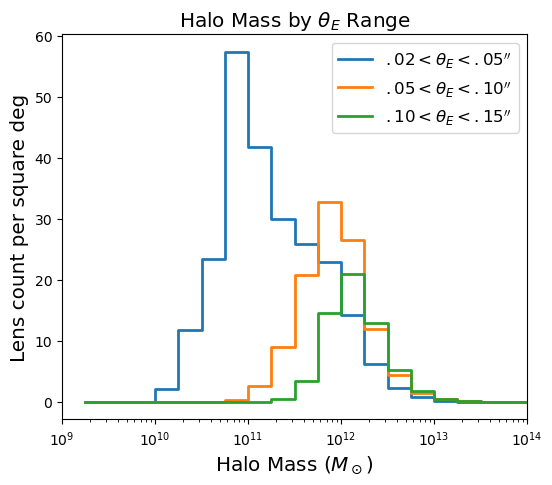

In [13]:
#Plot of forecast Halo Mass by Einstein radius range
bins=np.logspace(9,14,21)
sizes = [0.02, 0.05, 0.10, 0.15]
tots = np.zeros((len(sizes)-1,len(bins)-1))

for bin_i in range(len(bins)-1):
    mass_conds = (masses_used.flat>bins[bin_i])*(masses_used.flat<bins[bin_i+1])
    for size_i in range(len(sizes)-1):
        TES_conds = (TES.flat>sizes[size_i])*(TES.flat<sizes[size_i+1])
        conds = TES_conds * mass_conds
        sources_per_lens = (sources_per_lens_002.flat)[conds].copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        tots[size_i,bin_i] = mu*np.sum(sel)/len(ms)/area_dc2
        

plt.figure(dpi=100,figsize=(6,5))
plt.step(bins[1:], tots[0,:], label=r"$.02<\theta_E<.05''$",linewidth=2)
plt.step(bins[1:], tots[1,:], label=r"$.05<\theta_E<.10''$",linewidth=2)
plt.step(bins[1:], tots[2,:],label=r"$.10<\theta_E<.15''$",linewidth=2)

plt.xlabel(r'Halo Mass ($M_\odot$)', fontsize='x-large')
plt.ylabel('Lens count per square deg', fontsize='x-large')
plt.title(r"Halo Mass by $\theta_E$ Range", fontsize='x-large')
plt.legend(fontsize='large', loc='upper right')
plt.xlim(1e9,1e14)
plt.xscale('log')

#frac with m<1e11
np.sum(tots[0,:8])/np.sum(tots[0,:])

# B/T Ratio

/tmp/ipykernel_1227302/2346596632.py:11: RuntimeWarning: invalid value encountered in long_scalars
  tots[bin_i] = np.sum(btr[mass_conds]>0.9)/len(btr[mass_conds])


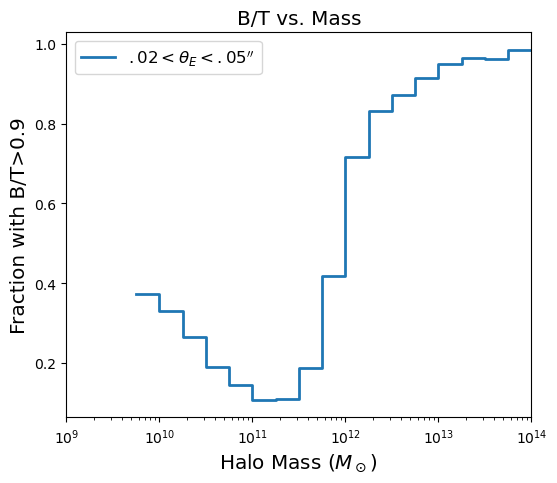

In [66]:
#Plot of B/T Ratio by Halo Mass
bins=np.logspace(9,14,21)
tots = np.zeros(len(bins)-1)

ms = dc2['halo_mass'][dc2['is_central']]
btr = dc2['bulge_to_total_ratio_i'][dc2['is_central']]

for bin_i in range(len(bins)-1):
    mass_conds = (ms.flat>bins[bin_i])*(ms.flat<bins[bin_i+1])
    
    tots[bin_i] = np.sum(btr[mass_conds]>0.9)/len(btr[mass_conds])
        

plt.figure(dpi=100,figsize=(6,5))
plt.step(bins[1:], tots, label=r"$.02<\theta_E<.05''$",linewidth=2)

plt.xlabel(r'Halo Mass ($M_\odot$)', fontsize='x-large')
plt.ylabel('Fraction with B/T>0.9', fontsize='x-large')
plt.title(r"B/T vs. Mass", fontsize='x-large')
plt.legend(fontsize='large', loc='upper left')
plt.xlim(1e9,1e14)
plt.xscale('log')

(3000000000.0, 200000000000000.0)

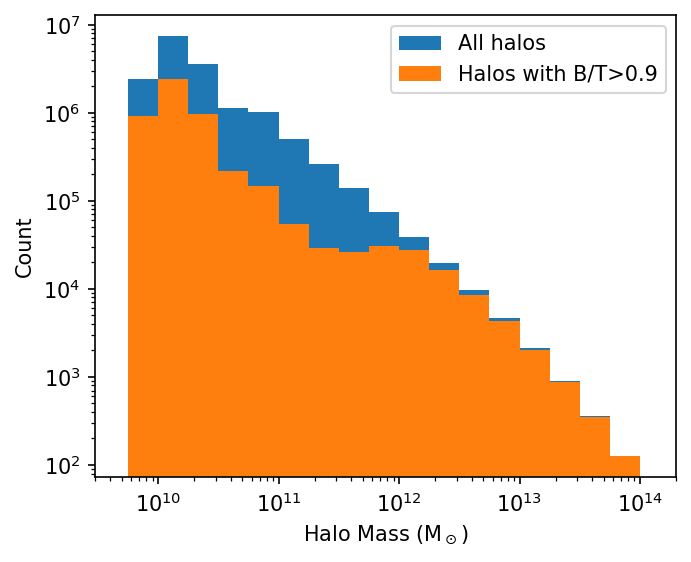

In [78]:
plt.figure(dpi=150,figsize=(5,4))
plt.hist(ms,bins=bins,log=True, label="All halos")
plt.hist(ms[btr>0.9],bins=bins,log=True, label="Halos with B/T>0.9")
plt.xscale('log')
plt.legend()
plt.xlabel(r'Halo Mass (M$_\odot$)')
plt.ylabel('Count'); plt.xlim(3e9,2e14)

# Lens Ratio

In [9]:
method='Collett'
method

'Collett'

In [28]:
#Statistical count, counting sources over lens area
import time
start = time.time()

#converts between normalization of Collett and CosmoDC2 distributions
number_ratio = 0.017399272857057335

#Total array of Einstein radii
TES=[]
#Masses of the lenses
masses_used=[]
#Sources per lens above 0.05", 0.1", 0.5", 1.0"
sources_per_lens_002, sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100 = [], [],[],[],[]

lens_masses = dc2['halo_mass'].copy()
#Lower mass limit is for speed, upper is to exclude huge cluster lenses
sel = (lens_masses>1e9)*(lens_masses<1e14)

ms = lens_masses[sel]
zs = dc2['redshift'][sel]
rng = np.random.default_rng(seed=5)
inds = rng.choice(len(ms), size=100000*sample_size_factor,replace=False)
inds = inds[dc2['is_central'][sel][inds]==True]

ms = ms[inds]
zs = zs[inds]
source_nums = np.zeros(len(z_source_means))
#Total lensed areas above 0.05", 0.1", 0.5", 1.0"
lens_areas_002 = np.zeros(len(z_source_means))
lens_areas_005 = np.zeros(len(z_source_means))
lens_areas_010 = np.zeros(len(z_source_means))
lens_areas_050 = np.zeros(len(z_source_means))
lens_areas_100 = np.zeros(len(z_source_means))

#Iterates over the redshift slices
for zi in (range(len(z_source_means))):
    sources = data[data['redshift']<z_sources[zi]]
    sources = sources[sources['redshift']>z_sources[zi+1]]
    
    source_areas = []

    #Counts all of the sources within the redshift bin that are bright enough
    for source in range(len(sources)):
        
#         R = int(sources[source]['Re_maj']/.03*5)
#         #counting if any pixel has brightness >5*BKG, using sep
#         if R>0:
#             ra, dec = sources[source]['RA'], sources[source]['DEC']
#             sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
#             x, y = w.world_to_pixel(sky)
#             x, y = int(x), int(y)
#             gal = data3[y-R:y+R,x-R:x+R]
#             objects, segmap = sep.extract(np.array(gal).byteswap().newbyteorder(), 1.5, err=bkg, segmentation_map=True)
#             segmap[segmap!=segmap[R,R]]=0
            
#             if np.count_nonzero(gal[segmap!=0]>5*bkg)>=1:
#                 source_nums[zi] += 1
#                 source_areas.append(np.sum(gal[segmap!=0]>5*bkg)*(.03/60/60)**2)
       
        #counting if brightness above a magnitude cut
        source_areas = [0]
        F_nu = sources[source]['HST_F775W_fnu']*1e-9
        ABmag = -2.5*np.log10(F_nu) + 8.90
        if ABmag < 26. and sources[source]['redshift']<1.0 and 10**sources[source]['SFR_100']>0.7:
            source_nums[zi] += 1

    TESz = []
    masses_used_z = []
    sources_per_lens_z_002, sources_per_lens_z_005,sources_per_lens_z_010,sources_per_lens_z_050,sources_per_lens_z_100  = [], [],[],[],[]
    #Counts the total lens area at the center of the current redshift slice
    for lens in tqdm(range(len(ms)), desc="Redshift Slice "+str(1+zi)+"/"+str(len(z_source_means)), leave=False):
        if zs[lens] < z_source_means[zi] and zs[lens]<0.4:
            lens_cosmo = LensCosmo(z_lens=zs[lens], z_source=z_source_means[zi])

            if method=='Zahid':
                alpha, beta, scatter = 0.16, 3.31, 0.17
                sig = 100*10**((np.log10(ms[lens]/1e12)-alpha)/beta)
                sig += norm.rvs(loc=0,scale=np.log(10)/beta*sig*0.17)
                
            elif method=='Collett':
                sig = np.random.choice(c_sig)
                # sig = c_sig[lens%len(c_sig)]
            else:
                raise Exception("Not a valid method.")
            
            theta_E = lens_cosmo.sis_sigma_v2theta_E(sig)
            if theta_E<0.5 or sig<100 or theta_E>1.5:
                theta_E = 0
            TESz.append(theta_E)
            masses_used_z.append(ms[lens])
            
            TEarea = np.pi*(theta_E/60/60)**2
            if len(source_areas)>0 and theta_E>0.5 and theta_E<1.5:
                #Source area
                sArea = np.random.choice(source_areas)
                source_radius = np.sqrt(sArea/np.pi)
                #Total radius is how far away the lens and source can be
                if counting=='source_in_lens':
                    total_radius = theta_E/60/60
                elif counting=='lens_in_source':
                    total_radius = source_radius
                elif counting=='both':
                    total_radius = max(source_radius, theta_E/60/60)
                else:
                    raise Exception("Not a valid counting choice.")
                TEarea = np.pi*(total_radius)**2
            else:
                TEarea=0
            
            #Counts the individual Einstein radius bins conveniently
            if theta_E>.02:
                sources_per_lens_z_002.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_002.append(0)
            if theta_E>.05:
                sources_per_lens_z_005.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_005.append(0)
            if theta_E>.10:
                sources_per_lens_z_010.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_010.append(0)
            if theta_E>.50:
                sources_per_lens_z_050.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_050.append(0)
            if theta_E>1.00:
                sources_per_lens_z_100.append(source_nums[zi]*TEarea/sad)
            else:
                sources_per_lens_z_100.append(0)

            if theta_E>.02:
                lens_areas_002[zi] += TEarea
            if theta_E>.05:
                lens_areas_005[zi] += TEarea
            if theta_E>0.10:
                lens_areas_010[zi] += TEarea
            if theta_E>0.50:
                lens_areas_050[zi] += TEarea
            if theta_E>1.00:
                # print(theta_E)
                lens_areas_100[zi] += TEarea
        else:
            TESz.append(0)
            masses_used_z.append(0)
            sources_per_lens_z_002.append(0),sources_per_lens_z_005.append(0),sources_per_lens_z_010.append(0),sources_per_lens_z_050.append(0),sources_per_lens_z_100.append(0)
    TESz = np.array(TESz)
    TES.append(TESz)

    masses_used_z = np.array(masses_used_z)
    masses_used.append(masses_used_z)
    
    sources_per_lens_002.append(np.array(sources_per_lens_z_002)),sources_per_lens_005.append(np.array(sources_per_lens_z_005)),sources_per_lens_010.append(np.array(sources_per_lens_z_010)),sources_per_lens_050.append(np.array(sources_per_lens_z_050)),sources_per_lens_100.append(np.array(sources_per_lens_z_100))
TES = np.array(TES)
masses_used = np.array(masses_used)

sources_per_lens_002 = np.array(sources_per_lens_002)
sources_per_lens_005 = np.array(sources_per_lens_005)
sources_per_lens_010 = np.array(sources_per_lens_010)
sources_per_lens_050 = np.array(sources_per_lens_050)
sources_per_lens_100 = np.array(sources_per_lens_100)
    
print(time.time()-start)
print()

def counts_per_deg(te):
    if te==0.02:
        lens_areas = lens_areas_002.copy()
    elif te==0.05:
        lens_areas = lens_areas_005.copy()
    elif te==0.10:
        lens_areas = lens_areas_010.copy()
    elif te==0.50:
        lens_areas = lens_areas_050.copy()
    elif te==1.00:
        lens_areas = lens_areas_100.copy()
    counts_per_deg = np.zeros(len(TES))
    for i in range(len(TES)):
        sources_per_deg = source_nums[i] / sad
        # lenses_per_deg = len(lenses)*len(masses2)/len(ms)/(11*11/60/60)

        counts_per_deg[i] = sources_per_deg * lens_areas[i] * np.sum(sel)/len(ms)/area_dc2
    print(te, np.sum(counts_per_deg), np.sum(source_nums/sad),np.sum(counts_per_deg)/np.sum(source_nums/sad))
    return np.sum(counts_per_deg)
print()  
a = np.array([counts_per_deg(.02),counts_per_deg(.05), counts_per_deg(.1), counts_per_deg(.5),  counts_per_deg(1)])
if method=='Collett':
    a = a*number_ratio
# print(a)
print(a*41523)

#n_max_counted = max number of sources to consider 
#(eg. 2 = up to double sources)
n_max_counted = 4
#tots needed for the normalization
tots = np.zeros(5)
j=-1
sizes = [0.02,.05,0.1,0.5,1.0]
for sources_per_lens_i in [sources_per_lens_002,sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100]:
    j += 1
    # print("_____"+str(sizes[j])+"_____")
    for i in range(1,n_max_counted+1):
        sources_per_lens = sources_per_lens_i.copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        ni = mu**i*np.e**(-mu)/np.math.factorial(i)
        if method=='Collett':
            ni = ni*number_ratio
        n_per_deg_i = np.sum(ni)*np.sum(sel)/len(ms)/area_dc2
        tots[j] += n_per_deg_i

/tmp/ipykernel_42807/1623271097.py:63: RuntimeWarning: divide by zero encountered in log10
  ABmag = -2.5*np.log10(F_nu) + 8.90


45.500160932540894


0.02 36.493940237885475 19611.38075347743 0.0018608552195599221
0.05 36.493940237885475 19611.38075347743 0.0018608552195599221
0.1 36.493940237885475 19611.38075347743 0.0018608552195599221
0.5 36.493940237885475 19611.38075347743 0.0018608552195599221
1 11.70061515988803 19611.38075347743 0.0005966237312389803
[26365.77725341 26365.77725341 26365.77725341 26365.77725341
  8453.34351464]


In [29]:
#Follows formatting of Tables 1 and 2 in the paper
#(Just sum the rows of N=1,2,etc for the totals in Table 2)

print("N | fraction | per deg | on sky")
sizes = [0.02,0.05,0.10,0.50,1.00]
j=-1
for sources_per_lens_i in [sources_per_lens_002,sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100]:
    j += 1
    print("_____>"+str(sizes[j])+'"_____')
    for i in range(1,n_max_counted+1):
        sources_per_lens = sources_per_lens_i.copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        ni = mu**i*np.e**(-mu)/np.math.factorial(i)
        if method=='Collett':
            ni *= number_ratio
        n_per_deg_i = np.sum(ni)*np.sum(sel)/len(ms)/area_dc2
        n_per_sky_i = n_per_deg_i * 41523
        print(i, round(n_per_deg_i/tots[j]*100,4), round(n_per_deg_i,4), round(n_per_sky_i,4))
        if j==0 and i==1:
            lens_pop = n_per_sky_i

N | fraction | per deg | on sky
_____>0.02"_____
1 99.9087 0.6338 26317.6703
2 0.0912 0.0006 24.0219
3 0.0001 0.0 0.0211
4 0.0 0.0 0.0
_____>0.05"_____
1 99.9087 0.6338 26317.6703
2 0.0912 0.0006 24.0219
3 0.0001 0.0 0.0211
4 0.0 0.0 0.0
_____>0.1"_____
1 99.9087 0.6338 26317.6703
2 0.0912 0.0006 24.0219
3 0.0001 0.0 0.0211
4 0.0 0.0 0.0
_____>0.5"_____
1 99.9087 0.6338 26317.6703
2 0.0912 0.0006 24.0219
3 0.0001 0.0 0.0211
4 0.0 0.0 0.0
_____>1.0"_____
1 99.8754 0.2031 8432.2854
2 0.1245 0.0003 10.5124
3 0.0001 0.0 0.0111
4 0.0 0.0 0.0


In [30]:
parent_pop = 0
for lens in tqdm(range(len(ms))):
    if True and zs[lens]<0.4:
        sig = np.random.choice(c_sig)
        if True and sig > 100:
            parent_pop += 1
parent_pop *= number_ratio *np.sum(sel)/len(ms)/area_dc2
parent_pop, parent_pop * 41523, parent_pop * 41523 / lens_pop

100%|██████████| 963859/963859 [00:00<00:00, 2829550.65it/s]


(692.5780588529587, 28757918.737751406, 1092.7228145993288)

# Forecast Detectable

In [27]:
def forecast_():
    #Total array of Einstein radii
    TES=[]
    #Masses of the lenses
    masses_used=[]
    #Sources per lens above 0.05", 0.1", 0.5", 1.0"
    sources_per_lens_002, sources_per_lens_005,sources_per_lens_010,sources_per_lens_050,sources_per_lens_100 = [], [],[],[],[]

    lens_masses = dc2['halo_mass'].copy()
    #Lower mass limit is for speed, upper is to exclude huge cluster lenses
    sel = (lens_masses>1e9)*(lens_masses<1e14)

    ms = lens_masses[sel]
    zs = dc2['redshift'][sel]
    btr = dc2['bulge_to_total_ratio_i'][sel]
    rng = np.random.default_rng(seed=5)
    np.random.seed(5)
    inds = rng.choice(len(ms), size=100000*sample_size_factor,replace=False)
    inds = inds[dc2['is_central'][sel][inds]==True]

    ms = ms[inds]
    zs = zs[inds]
    btr = btr[inds]
    source_nums = np.zeros(len(z_source_means))
    #Total lensed areas above 0.05", 0.1", 0.5", 1.0"
    lens_areas_002 = np.zeros(len(z_source_means))
    lens_areas_005 = np.zeros(len(z_source_means))
    lens_areas_010 = np.zeros(len(z_source_means))
    lens_areas_050 = np.zeros(len(z_source_means))
    lens_areas_100 = np.zeros(len(z_source_means))

    #Iterates over the redshift slices
    for zi in (range(len(z_source_means))):
        sources = data[data['redshift']<z_sources[zi]]
        sources = sources[sources['redshift']>z_sources[zi+1]]

        source_areas = []

        #Counts all of the sources within the redshift bin that are bright enough
        for source in range(len(sources)):
            R = int(sources[source]['Re_maj']/.03*5)
            #counting if any pixel has brightness >5*BKG, using sep
            if R>0:
                ra, dec = sources[source]['RA'], sources[source]['DEC']
                sky = SkyCoord(str(ra)+"d "+str(dec)+"d")
                x, y = w.world_to_pixel(sky)
                x, y = int(x), int(y)
                gal = data3[y-R:y+R,x-R:x+R]
                objects, segmap = sep.extract(np.array(gal).byteswap().newbyteorder(), 1.5, err=bkg, segmentation_map=True)
                segmap[segmap!=segmap[R,R]]=0

                if np.count_nonzero(gal[segmap!=0]>5*bkg)>=1:
                    source_nums[zi] += 1
                    source_areas.append(np.sum(gal[segmap!=0]>5*bkg)*(.03/60/60)**2)

            # #counting if brightness above a magnitude cut
            # F_nu = sources[source]['HST_F775W_fnu']*1e-9
            # ABmag = -2.5*np.log10(F_nu) + 8.90
            # if ABmag < 27:
            #     source_nums[zi] += 1

        TESz = []
        masses_used_z = []
        sources_per_lens_z_002, sources_per_lens_z_005,sources_per_lens_z_010,sources_per_lens_z_050,sources_per_lens_z_100  = [], [],[],[],[]
        #Counts the total lens area at the center of the current redshift slice
        for lens in tqdm(range(len(ms)), desc="Redshift Slice "+str(1+zi)+"/"+str(len(z_source_means)), leave=False):
            if zs[lens] < z_source_means[zi] and (not btr_enforced or btr[lens]>0.9):
                lens_cosmo = LensCosmo(z_lens=zs[lens], z_source=z_source_means[zi])

                if method=='Zahid':
                    alpha, beta, scatter = 0.16, 3.31, 0.17
                    sig = 100*10**((np.log10(ms[lens]/1e12)-alpha)/beta)
                    sig += norm.rvs(loc=0,scale=np.log(10)/beta*sig*0.17)

                elif method=='Collett':
                    sig = np.random.choice(c_sig)
                else:
                    raise Exception("Not a valid method.")

                theta_E = lens_cosmo.sis_sigma_v2theta_E(sig)
                TESz.append(theta_E)
                masses_used_z.append(ms[lens])

                TEarea = np.pi*(theta_E/60/60)**2
                if len(source_areas)>0:
                    #Source area
                    sArea = np.random.choice(source_areas)
                    source_radius = np.sqrt(sArea/np.pi)
                    #Total radius is how far away the lens and source can be
                    if counting=='source_in_lens':
                        total_radius = theta_E/60/60
                    elif counting=='lens_in_source':
                        total_radius = source_radius
                    elif counting=='both':
                        total_radius = max(source_radius, theta_E/60/60)
                    else:
                        raise Exception("Not a valid counting choice.")
                    TEarea = np.pi*(total_radius)**2
                else:
                    Tearea=0

                #Counts the individual Einstein radius bins conveniently
                if theta_E>.02:
                    sources_per_lens_z_002.append(source_nums[zi]*TEarea/sad)
                else:
                    sources_per_lens_z_002.append(0)
                if theta_E>.05:
                    sources_per_lens_z_005.append(source_nums[zi]*TEarea/sad)
                else:
                    sources_per_lens_z_005.append(0)
                if theta_E>.10:
                    sources_per_lens_z_010.append(source_nums[zi]*TEarea/sad)
                else:
                    sources_per_lens_z_010.append(0)
                if theta_E>.50:
                    sources_per_lens_z_050.append(source_nums[zi]*TEarea/sad)
                else:
                    sources_per_lens_z_050.append(0)
                if theta_E>1.00:
                    sources_per_lens_z_100.append(source_nums[zi]*TEarea/sad)
                else:
                    sources_per_lens_z_100.append(0)

                if theta_E>.02:
                    lens_areas_002[zi] += TEarea
                if theta_E>.05:
                    lens_areas_005[zi] += TEarea
                if theta_E>0.10:
                    lens_areas_010[zi] += TEarea
                if theta_E>0.50:
                    lens_areas_050[zi] += TEarea
                if theta_E>1.00:
                    # print(theta_E)
                    lens_areas_100[zi] += TEarea
            else:
                TESz.append(0)
                masses_used_z.append(0)
                sources_per_lens_z_002.append(0),sources_per_lens_z_005.append(0),sources_per_lens_z_010.append(0),sources_per_lens_z_050.append(0),sources_per_lens_z_100.append(0)
        TESz = np.array(TESz)
        TES.append(TESz)

        masses_used_z = np.array(masses_used_z)
        masses_used.append(masses_used_z)

        sources_per_lens_002.append(np.array(sources_per_lens_z_002)),sources_per_lens_005.append(np.array(sources_per_lens_z_005)),sources_per_lens_010.append(np.array(sources_per_lens_z_010)),sources_per_lens_050.append(np.array(sources_per_lens_z_050)),sources_per_lens_100.append(np.array(sources_per_lens_z_100))
    TES = np.array(TES)
    masses_used = np.array(masses_used)

    sources_per_lens_002 = np.array(sources_per_lens_002)
    sources_per_lens_005 = np.array(sources_per_lens_005)
    sources_per_lens_010 = np.array(sources_per_lens_010)
    sources_per_lens_050 = np.array(sources_per_lens_050)
    sources_per_lens_100 = np.array(sources_per_lens_100)
    if method=='Collett':
        sources_per_lens_002 = sources_per_lens_002*number_ratio
        sources_per_lens_005 = sources_per_lens_005*number_ratio
        sources_per_lens_010 = sources_per_lens_010*number_ratio
        sources_per_lens_050 = sources_per_lens_050*number_ratio
        sources_per_lens_100 = sources_per_lens_100*number_ratio
        
    return TES, masses_used, sources_per_lens_002, sel, ms

In [28]:
start = time.time()
countings = ['source_in_lens','lens_in_source', 'both']
TES_, masses_used_, sources_per_lens_002_, sel_, ms_ = [], [], [], [], []
for counting_i in range(3):
    counting = countings[counting_i]
    TES, masses_used, sources_per_lens_002, sel, ms = forecast_()
    TES_.append(TES), masses_used_.append(masses_used), sources_per_lens_002_.append(sources_per_lens_002), sel_.append(sel), ms_.append(ms)
print(time.time()-start)

14259.334198713303


100%|██████████| 15/15 [00:07<00:00,  2.09it/s]


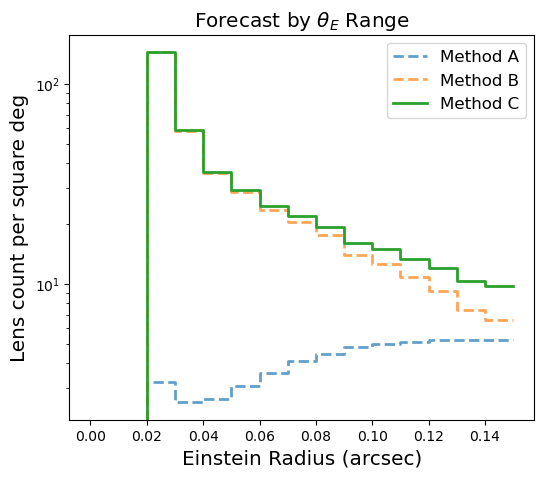

In [29]:
#Plot of forecast numbers by Einstein radius for A, B, C
start = time.time()
bins = np.arange(0,.16,.01)
tots = np.zeros((3,len(bins)))
for i in range(3):
    TES, masses_used, sources_per_lens_002, sel, ms = TES_[i], masses_used_[i], sources_per_lens_002_[i], sel_[i], ms_[i]
    for bin_i in tqdm(range(len(bins)-1)):
        TES_conds = (TES.flat>max(bins[bin_i],.02))*(TES.flat<bins[bin_i+1])
        sources_per_lens = (sources_per_lens_002.flat)[TES_conds].copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        tots[i,bin_i] = mu*np.sum(sel)/len(ms)/area_dc2
    tots[i,-1] = tots[i,-2]
    
plt.figure(dpi=100,figsize=(6,5))
plt.step(bins[:], tots[0,:], label=r"Method A",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[1,:], label=r"Method B",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[2,:],label=r"Method C",linewidth=2, where='post')

plt.xlabel(r'Einstein Radius (arcsec)', fontsize='x-large')
plt.ylabel('Lens count per square deg', fontsize='x-large')
plt.title(r"Forecast by $\theta_E$ Range", fontsize='x-large')
plt.legend(fontsize='large', loc='upper right')
plt.yscale('log')

In [30]:
overall_tots = tots[2,:]
print(".02''-.05'':",overall_tots[2:5].sum())
print(".05''-.10'':",overall_tots[5:10].sum())
print(".10''-.15'':",overall_tots[10:16].sum())

.02''-.05'': 239.2521425614469
.05''-.10'': 110.66433439853922
.10''-.15'': 69.79502510641353


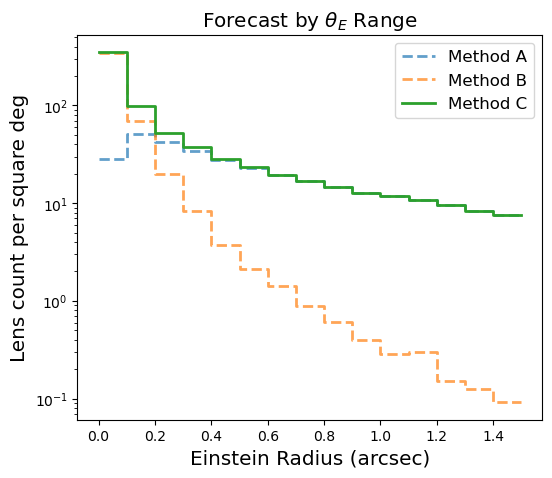

In [32]:
#Plot of forecast numbers by Einstein radius for A, B, C
bins = np.arange(0,1.6,.1)
tots = np.zeros((3,len(bins)))

for i in range(3):
    TES, masses_used, sources_per_lens_002, sel, ms = TES_[i], masses_used_[i], sources_per_lens_002_[i], sel_[i], ms_[i]
    for bin_i in range(len(bins)-1):
        TES_conds = (TES.flat>max(bins[bin_i],.02))*(TES.flat<bins[bin_i+1])
        sources_per_lens = (sources_per_lens_002.flat)[TES_conds].copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        tots[i,bin_i] = mu*np.sum(sel)/len(ms)/area_dc2
    tots[i,-1] = tots[i,-2]
    
plt.figure(dpi=100,figsize=(6,5))
plt.step(bins[:], tots[0,:], label=r"Method A",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[1,:], label=r"Method B",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[2,:],label=r"Method C",linewidth=2, where='post')

plt.xlabel(r'Einstein Radius (arcsec)', fontsize='x-large')
plt.ylabel('Lens count per square deg', fontsize='x-large')
plt.title(r"Forecast by $\theta_E$ Range", fontsize='x-large')
plt.legend(fontsize='large', loc='upper right')
plt.yscale('log')

/tmp/ipykernel_1550349/125128642.py:15: RuntimeWarning: invalid value encountered in long_scalars
  frac_less_1e11[bin_i] = np.sum(TES_conds*mass_conds)/np.sum(TES_conds)


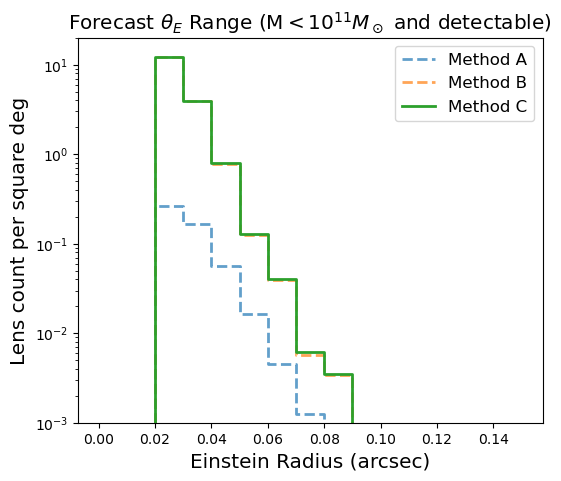

In [33]:
#Plot accounting for recall rate at 0.96 threshold
bins = np.arange(0,.16,.01)
tots = np.zeros((3,len(bins)))
frac_less_1e11 = np.zeros(len(bins))

frac_right = 1 - np.array([1.        ,        1., 0.85204082, 0.66315789, 0.52884615,
        0.3968254 , 0.32386364, 0.20529801, 0.12751678, 0.12149533,
        0.13605442, 0.10596026, 0.07633588, 0.14      , 0.10377358,  0.10377358])

for i in range(3):
    TES, masses_used, sources_per_lens_002, sel, ms = TES_[i], masses_used_[i], sources_per_lens_002_[i], sel_[i], ms_[i]
    for bin_i in range(len(bins)-1):
        TES_conds = (TES.flat>max(bins[bin_i],.02))*(TES.flat<bins[bin_i+1])
        mass_conds = masses_used.flat<1e11
        frac_less_1e11[bin_i] = np.sum(TES_conds*mass_conds)/np.sum(TES_conds)
        sources_per_lens = (sources_per_lens_002.flat)[TES_conds*mass_conds].copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        tots[i,bin_i] = mu*np.sum(sel)/len(ms)/area_dc2
        if i==2:
            tots[i,bin_i] = np.max(tots[:,bin_i])
    tots[i,-1] = tots[i,-2]
    frac_less_1e11[-1] = frac_less_1e11[-2]
    
plt.figure(dpi=100,figsize=(6,5))
plt.step(bins[:], tots[0,:]*frac_right, label=r"Method A",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[1,:]*frac_right, label=r"Method B",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[2,:]*frac_right,label=r"Method C",linewidth=2, where='post')

plt.ylim(1e-3,2e1)
plt.xlabel(r'Einstein Radius (arcsec)', fontsize='x-large')
plt.ylabel('Lens count per square deg', fontsize='x-large')
plt.title(r"Forecast $\theta_E$ Range (M$<10^{11}M_\odot$ and detectable)", fontsize='x-large')
plt.legend(fontsize='large', loc='upper right')
plt.yscale('log')

In [38]:
overall_tots = tots[2,:]*frac_right
print(".02''-.05'':",overall_tots[2:5].sum())
print(".05''-.10'':",overall_tots[5:10].sum())
print(".10''-.15'':",overall_tots[10:16].sum())

.02''-.05'': 16.791670957730904
.05''-.10'': 0.1802360696902211
.10''-.15'': 0.0


/tmp/ipykernel_1550349/2967388565.py:19: RuntimeWarning: invalid value encountered in long_scalars
  frac_less_1e11[bin_i] = np.sum(TES_conds*mass_conds)/np.sum(TES_conds)


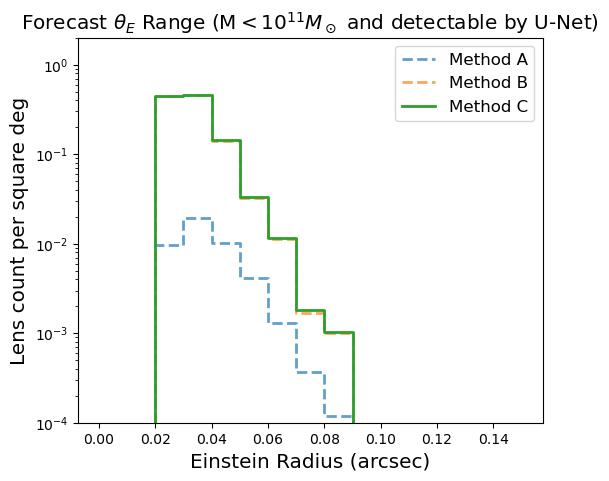

In [35]:
#Plot accounting for recall rate at 0.96 threshold
bins = np.arange(0,.16,.01)
tots = np.zeros((3,len(bins)))
frac_less_1e11 = np.zeros(len(bins))

frac_unet = np.array([1., 1., 0.03703704, 0.11666667, 0.18181818, 0.25438596, 0.28448276, 0.29310345,
 0.29457364, 0.24210526, 0.25384615, 0.15671642, 0.20661157, 0.29885057,
 0.19148936,0.19148936])
frac_unet_05 = np.array([1.,1.,0.37037037, 0.51666667, 0.67676768, 0.70175439, 0.70689655, 0.77586207,
 0.72093023, 0.71578947, 0.73846154, 0.64925373, 0.75206612, 0.74712644,
 0.61702128, 0.61702128])


for i in range(3):
    TES, masses_used, sources_per_lens_002, sel, ms = TES_[i], masses_used_[i], sources_per_lens_002_[i], sel_[i], ms_[i]
    for bin_i in range(len(bins)-1):
        TES_conds = (TES.flat>max(bins[bin_i],.02))*(TES.flat<bins[bin_i+1])
        mass_conds = masses_used.flat<1e11
        frac_less_1e11[bin_i] = np.sum(TES_conds*mass_conds)/np.sum(TES_conds)
        sources_per_lens = (sources_per_lens_002.flat)[TES_conds*mass_conds].copy()
        mu = np.array(sources_per_lens.sum(axis=0))
        tots[i,bin_i] = mu*np.sum(sel)/len(ms)/area_dc2
        if i==2:
            tots[i,bin_i] = np.max(tots[:,bin_i])
    tots[i,-1] = tots[i,-2]
    frac_less_1e11[-1] = frac_less_1e11[-2]
    
plt.figure(dpi=100,figsize=(6,5))
plt.step(bins[:], tots[0,:]*frac_right*frac_unet, label=r"Method A",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[1,:]*frac_right*frac_unet, label=r"Method B",linewidth=2, where='post',linestyle="--",alpha=0.7)
plt.step(bins[:], tots[2,:]*frac_right*frac_unet,label=r"Method C",linewidth=2, where='post')

plt.ylim(1e-4,2e0)
plt.xlabel(r'Einstein Radius (arcsec)', fontsize='x-large')
plt.ylabel('Lens count per square deg', fontsize='x-large')
plt.title(r"Forecast $\theta_E$ Range (M$<10^{11}M_\odot$ and detectable by U-Net)", fontsize='x-large')
plt.legend(fontsize='large', loc='upper right')
plt.yscale('log')

In [36]:
overall_tots = tots[2,:]*frac_right*frac_unet
print(".02''-.05'':",overall_tots[2:5].sum())
print(".05''-.10'':",overall_tots[5:10].sum())
print(".10''-.15'':",overall_tots[10:16].sum())

.02''-.05'': 1.0515044883173021
.05''-.10'': 0.04745309709629242
.10''-.15'': 0.0


In [37]:
overall_tots = tots[2,:]*frac_right*frac_unet_05
print(".02''-.05'':",overall_tots[2:5].sum())
print(".05''-.10'':",overall_tots[5:10].sum())
print(".10''-.15'':",overall_tots[10:16].sum())

.02''-.05'': 7.04018154154773
.05''-.10'': 0.12721159749212835
.10''-.15'': 0.0


(-0.05, 1.05)

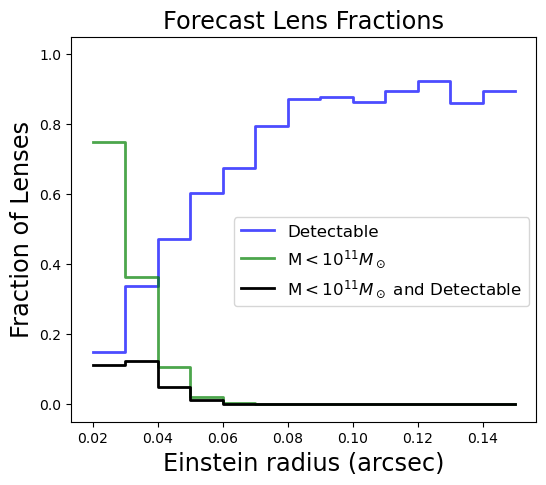

In [29]:
plt.figure(dpi=100,figsize=(6,5))
plt.step(bins[2:], frac_right[2:], c="blue", alpha=0.7, label=r"Detectable",linewidth=2, where='post')
plt.step(bins[2:], frac_less_1e11[2:], c="green", alpha=0.7, label=r"M$<10^{11}M_\odot$",linewidth=2, where='post')
plt.step(bins[2:], frac_less_1e11[2:]*frac_right[2:], c="k", label=r"M$<10^{11}M_\odot$ and Detectable",linewidth=2, where='post')
plt.xlabel('Einstein radius (arcsec)', fontsize='xx-large')
plt.ylabel('Fraction of Lenses', fontsize='xx-large')
plt.title('Fraction of Lenses with M$<10^{11}M_\odot$ or Detectable', fontsize='x-large')
plt.title('Forecast Lens Fractions', fontsize='xx-large')
plt.legend(loc=(.35,.3),fontsize='large'); plt.ylim(-.05,1.05)